# **Домашнее задание**

1. обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта
2. при обучении моделей обязательно использовать кроссвалидацию
3. вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)
4. сделать выводы о том, какая модель справилась с задачей лучше других
5. (опциональный вопрос) какая метрика (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого). 

p.s.В вопросе проще разобраться, если вспомнить оси на графике roc auc curve и рассмотреть такой пример:

Имеется 100000 объектов, из которых только 100 - класс "1" (99900 - класс "0", соответственно). 
Допустим, у нас две модели:

- первая помечает 100 объектов как класс 1, но TP = 90
- вторая помечает 1000 объектов как класс 1, но TP такой же - 90

Какая модель лучше и почему? И что позволяет легче сделать вывод - roc_auc_curve или precision_recall_curve?


In [24]:
import numpy as np
import pandas as pd
import itertools

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
!ls /content/gdrive/MyDrive/'Colab Notebooks'/ML_in_business/les_03

HW_03.ipynb  kc_house_data.csv	train_case2.csv  train.csv


In [5]:
df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/ML_in_business/les_03/train_case2.csv', ';')
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


In [6]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), 
                                                    df['cardio'], random_state=0)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((52500, 12), (52500,), (17500, 12), (17500,))

К полям:
- gender, cholesterol применим OHE-кодирование
- age, height, weight, ap_hi, ap_lo - standardScaler
- gluc, smoke, alco, active - оставим пока как есть

In [7]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]

In [8]:
continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

In [9]:
feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

In [10]:
models_list = {"LogisticReg": LogisticRegression(C = 0.10,random_state = 42), 
               "RandomForest": RandomForestClassifier(random_state = 42), 
               "GradientBoosting": GradientBoostingClassifier(random_state = 42)
               }

classifiers_list = []
y_score_dict = {}

for key, value in models_list.items():
    classifier = Pipeline([
        ('features',feats),
        ('classifier', value),
    ])
    classifiers_list.append(classifier)

    #запустим кросс-валидацию
    cv_scores = cross_val_score(classifier, X_train, y_train, cv=6, scoring='roc_auc')
    cv_score = np.mean(cv_scores)
    cv_score_std = np.std(cv_scores)
  
    print(f'{key}.\tCV score is {cv_score}.\tCV score_std is {cv_score_std}')

    #обучим пайплайн на всем тренировочном датасете
    classifier.fit(X_train, y_train)
    y_score_dict[key] = classifier.predict_proba(X_test)[:, 1]

LogisticReg.	CV score is 0.7844374123135694.	CV score_std is 0.005286474572634387
RandomForest.	CV score is 0.775500216390547.	CV score_std is 0.002836899882861481
GradientBoosting.	CV score is 0.8023377962657184.	CV score_std is 0.004150757612691979


In [12]:
def calc_metrics(y_test, preds):

    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    fscore = (2 * precision * recall) / (precision + recall)
    
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    
    roc_auc = roc_auc_score(y_test, preds)
    
    return thresholds[ix], fscore[ix], precision[ix], recall[ix], roc_auc

In [13]:
metrics = []

for key, value in y_score_dict.items():
    threshold, fscore, precision, recall, roc_auc = calc_metrics(y_test, value)
    metrics.append([threshold, fscore, precision, recall, roc_auc])

In [14]:
metrics_df = pd.DataFrame(metrics,
                          columns = ['threshold', 'f-score', 'precision', 'recall', 'roc_auc'],
                          index = y_score_dict.keys())
metrics_df

,threshold,f-score,precision,recall,roc_auc
LogisticReg,0.389193,0.728938,0.644507,0.838825,0.781981
RandomForest,0.350000,0.718863,0.642669,0.815553,0.771037
GradientBoosting,0.394947,0.740248,0.697848,0.788134,0.802615


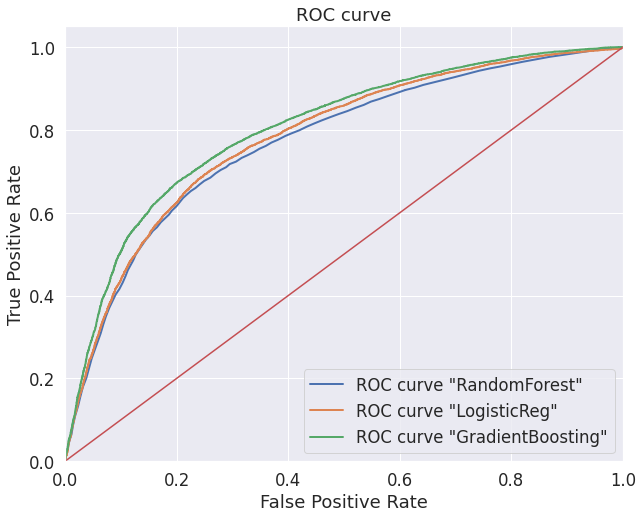

In [15]:
# сделать функцию рок кривая
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr2, tpr2, thresholds_ = roc_curve(y_test, y_score_dict["RandomForest"], pos_label=1)
fpr3, tpr3, thresholds_ = roc_curve(y_test, y_score_dict["LogisticReg"], pos_label=1)
fpr4, tpr4, thresholds_ = roc_curve(y_test, y_score_dict["GradientBoosting"], pos_label=1)
lw = 2

plt.plot(fpr2, tpr2, lw=lw, label='ROC curve "RandomForest"')
plt.plot(fpr3, tpr3, lw=lw, label='ROC curve "LogisticReg"')
plt.plot(fpr4, tpr4, lw=lw, label='ROC curve "GradientBoosting"')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend()
plt.savefig("ROC.png")
plt.show()

вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)
сделать выводы о том, какая модель справилась с задачей лучше других

**Выводы: Бустинг справился лучше других. только по recall лучше лог. регрессия, то есть если для бизнеса важнее recall, можно выбрать лог. регрессию.**

(опциональный вопрос) какая метрика (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого).
p.s.В вопросе проще разобраться, если вспомнить оси на графике roc auc curve и рассмотреть такой пример:

Имеется 100000 объектов, из которых только 100 - класс "1" (99900 - класс "0", соответственно). Допустим, у нас две модели:

первая помечает 100 объектов как класс 1, но TP = 90

вторая помечает 1000 объектов как класс 1, но TP такой же - 90
Какая модель лучше и почему? И что позволяет легче сделать вывод - roc_auc_curve или precision_recall_curve?

**Ответ: здесь дисбаланс классов большой, поэтому precision_recall_curve здесь будет лучше, так как в она не учитывает TRUE NEGATIVE то есть то, что и является дисбалансом, большим числом. 
так как в расчетах precision и recall TN не используется, сравнение будет более верным, чем по roc_auc_curve, которая учитывает TN.**